이번 편에서는, 이전에 해볼만하다고 느꼈던 **시간에 따른 따릉이 대여건수 예측**을 해본다.  
어떻게 따릉이 대여건수를 예측할 것이냐. 기본 아이디어는 Kaggle의 유명한 Competition 이었던, Bike sharing demand 문제해결과 동일하다.  
즉, 한마디로 말해, **기본 자전거 이용량 데이터 + 날씨 데이터** 로 대여건수를 예측한다.  
한 시간뒤의 대여건수를 명확히 알 수는 없으나, 한 시간뒤의 날씨 데이터는 비교적 명확히 알 수 있고, 기상청에서 미리 공개된다.  
따라서, 미래의 대여건수를 날씨예보를 활용하여 어느정도 예측이 가능할 거란 이야기다. 이는 Bike sharing demand 문제에서도 해결한 방식이다.  

우리가 풀어야하는 문제는 **회귀(Regression) 문제**이다.  
빠르게 만드는게 목적이므로, scikit-learn 에 있는 선형회귀 모델들을 거의 다 가져다 쓸 것이며, 이 모델들이 뭔지, 어떻게 작동하는지는 일단은 크게 관심 없다.
(근데 또 왠만한 선형화귀모델들은 유명하기도 하고, 검색하면 금방 나온다. 근데 또 굳이 지금 다 알 필요는 없을 듯 하다.)
한편 Kaggle 에서 가장 강력한 모델 중 하나인 xgboost 도 써볼 것이다. xgboost 는 어느정도 이해할 필요가 있는 모델인데, 추후 따로 정리하는 글을 쓸 예정이다.


사용하는 데이터는 **2018년 1월-11월 데이터, 그리고 마포구 지역**만 시도해보기로 한다.
이전 따릉이 EDA에서 살펴봤듯, 따릉이는 1년을 주기로 같은 패턴을 그리고, 연 단위로 전체적인 양이 차이가 나기 때문에, 1년치만 뽑아온 것이다.  
또, 전 지역의 모든 대여소에 대해서 모델 만드는 것을, 하면 할 수 있으나, 마포구만 먼저 해보고 실제로 모델이 작동하는지 정도만 살펴본다.  
하나만 되면, 다른 대여소에 대해서도 같은 방식으로 (사실상 복사 붙여넣기) 하면 된다.

쥬피터 랩에서 바로 md형식으로 변환하여 글을 올린다.  
즉, 결과만 쓰는게 아니라, **로드 및 전처리에 관련된 것까지 모두 게시**된다.
글 하단에 링크해놓은 노트북과 내용은 완전히 동일하다.

## 1. 데이터 로드 & 전처리

### 1) 따릉이 데이터 로드

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'AppleGothic'

In [2]:
import os

dirs = os.getcwd() + '/data/' + '서울시 공공자전거 이용현황(시간별)/'
files = os.listdir(dirs)
files

['서울특별시 공공자전거 시간대별 대여정보_201801_02.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201803_04.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201805.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201806.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201807.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201808.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201809.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201810.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201811.xlsx',
 '서울특별시 공공자전거 이용정보(시간대별)_2017년_1.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_2017년_2.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_2017년_3.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_2017년_4.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_2017년_5.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_2017년_6.c

18년도 데이터만 먼저 가져와보자.

In [3]:
files = [file for file in files if '2018' in file]
files

['서울특별시 공공자전거 시간대별 대여정보_201801_02.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201803_04.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201805.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201806.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201807.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201808.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201809.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201810.xlsx',
 '서울특별시 공공자전거 시간대별 대여정보_201811.xlsx']

데이터 프레임 만들자.  
그 전에, 빠른 데이터프레임 로딩을 위해, 열별로 자료형 잡아주자. (사전에 미리 확인함.)

In [4]:
column_types = {
    '대여일자': 'datetime64[ns]',
    '대여시간': 'int32',
    '대여소번호': 'category',
    '대여소명': 'category',
    '대여구분코드': 'category',
    '성별': 'category',
    '연령대코드': 'category',
    '이용건수': 'int32',
    '운동량': 'float32',
    '탄소량': 'float32',
    '이동거리': 'int32',
    '이동시간': 'int32',
}

In [5]:
try:
    df = pd.read_pickle('data/dataframes/2018.pkl')
except:
    df = pd.DataFrame()

    total = len(files)
    for i, file in enumerate(files, 1):
        print("%d/%d loaded..." %(i, total))

        formatter = file.split('.')[1]
        if formatter == 'xlsx':
            _df = pd.read_excel(dirs + file,
                                dtype = column_types,)
        elif formatter == 'csv':
            _df = pd.read_csv(dirs + file,
                         dtype = column_types,
                         parse_dates = ['대여일자'],
                         encoding='utf-8',
                        )
        df = pd.concat([df, _df])

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986984 entries, 0 to 465714
Data columns (total 12 columns):
대여일자      datetime64[ns]
대여시간      int32
대여소번호     int64
대여소명      category
대여구분코드    category
성별        category
연령대코드     category
이용건수      int32
운동량       float32
탄소량       float32
이동거리      int32
이동시간      int32
dtypes: category(4), datetime64[ns](1), float32(2), int32(4), int64(1)
memory usage: 302.8 MB


read_pickle 로 데이터프레임을 가져오지 않은 경우, 대여소명이 category로 안되어있다. 이거 바꿔주자.

In [7]:
df['대여소명'] = df['대여소명'].astype('category')

In [8]:
df.shape

(5986984, 12)

In [9]:
df.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,이동시간
0,2018-01-01,0,300,정동사거리,정기권,F,~10대,1,37.320000,0.34,1450,23
1,2018-01-01,0,505,자양사거리 광진아크로텔 앞,정기권,F,20대,1,54.830002,0.49,2130,15
2,2018-01-01,0,1531,미아사거리 1번 출구,정기권,F,20대,1,78.339996,0.73,3140,17
3,2018-01-01,0,516,광진메디칼 앞,정기권,F,20대,1,29.950001,0.29,1240,5
4,2018-01-01,0,3508,화양사거리,정기권,F,20대,1,46.090000,0.45,1940,43


In [10]:
df.tail()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,이동시간
465710,2018-11-30,23,2239,교대역 6번출구,일일권,M,30대,1,425.779999,2.08,8960,61
465711,2018-11-30,23,1210,롯데월드타워(잠실역2번출구 쪽),일일권,M,30대,1,32.150002,0.23,990,5
465712,2018-11-30,23,1162,공항초등학교건너편,일일권,M,40대,1,40.730000,0.28,1210,7
465713,2018-11-30,23,1288,문정중교 사거리,일일권,M,60대,1,18.299999,0.18,770,3
465714,2018-11-30,23,2184,구암초등학교 버스정류장,일일권(비회원),M,30대,1,40.930000,0.37,1590,12


추후 또 로딩하기 귀찮으므로, 피클라이저 해놓자.

In [11]:
df.to_pickle('data/dataframes/2018.pkl')

### 2) 마포구만 추출하자.

먼저, 위 데이터에는, 지역구에 대한 정보가 없다.  
따라서, 대여소번호로 마포구에 있는 데이터만 뽑아와야 하는데, 일단 마포구에는 어떤 대여소번호들이 있는지부터 확보하자.  
이를 위해, 대여소 데이터를 로드하자.

In [12]:
rentals = pd.read_csv("data/서울특별시 공공자전거 대여소 정보.csv")
rentals.head()

,구명,대여소ID,대여소번호,대여소명,대여소 주소,거치대수,위도,경도
0,강남구,ST-777,2301,현대고등학교 건너편,서울특별시 강남구 압구정로 134현대고등학교 건너편,10,37.524071,127.021790
1,강남구,ST-787,2302,교보타워 버스정류장(신논현역 3번출구 후면),서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장,10,37.505581,127.024277
2,강남구,ST-788,2303,논현역 7번출구,서울특별시 강남구 학동로 지하 102논현역 7번출구,15,37.511517,127.021477
3,강남구,ST-789,2304,신영 ROYAL PALACE 앞,서울특별시 강남구 언주로 626신영 ROYAL PALACE앞,10,37.512527,127.035835
4,강남구,ST-790,2305,MCM 본사 직영점 앞,서울특별시 강남구 언주로 734MCM 본사 직영점 앞,10,37.520641,127.034508


마포에 해당하는 대여소 번호만 뽑아보자.

In [13]:
rental_no = rentals.groupby('구명')['대여소번호'].unique().loc['마포구']
rental_no

array([ 101,  102,  103,  104,  105,  106,  107,  108,  109,  111,  112,
        113,  114,  118,  119,  120,  121,  122,  124,  125,  126,  127,
        129,  130,  136,  142,  143,  144,  145,  146,  147,  148,  150,
        151,  152,  153,  154,  155,  156,  157, 1687,  181,  182,  183,
        184,  185,  186,  199,  400,  401,  402,  403,  405,  406,  407,
        408,  409,  410,  411,  412,  413,  414,  415,  416,  417,  418,
        419,  420,  421,  422,  424,  425,  426,  427,  432])

이제 df (따릉이 데이터) 에서 마포구에 해당하는 대여정보만 뽑아오자.

In [14]:
df = df[df['대여소번호'].isin(rental_no)]
df.shape

(554200, 12)

5986984 -> 554200 로 줄어든 것을 볼 수 있다.

한편, 대여소 데이터에서 '거치대수' 도 피처로 쓰일 수 있지 않을까?  
혹시 모르니, 이 값도 df 에 합쳐주자.

In [15]:
df = df.merge(rentals[['대여소번호', '거치대수']], on='대여소번호')

### 3) 날씨 데이터를 불러와서 합치자.

미리 다운받아 놓은 마포구 날씨데이터를 불러오자.

In [17]:
weather = pd.read_csv('data/2018 마포 날씨.csv', encoding='cp949')
weather.head()

,지점,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,411,2018-01-01 01:00,-2.0,334.4,2.0,0.0,42.2
1,411,2018-01-01 02:00,-2.6,305.5,2.0,0.0,42.7
2,411,2018-01-01 03:00,-2.6,308.1,1.1,0.0,46.3
3,411,2018-01-01 04:00,-2.9,314.8,1.0,0.0,49.6
4,411,2018-01-01 05:00,-2.7,289.6,2.1,0.0,49.3


In [18]:
weather.shape

(8700, 7)

In [19]:
weather['일시'] = weather['일시'].astype('datetime64[ns]')
weather['월'] = weather['일시'].dt.month
weather['일'] = weather['일시'].dt.day
weather['대여시간'] = weather['일시'].dt.hour

In [20]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 10 columns):
지점         8700 non-null int64
일시         8700 non-null datetime64[ns]
기온(°C)     8689 non-null float64
풍향(deg)    8645 non-null float64
풍속(m/s)    8645 non-null float64
강수량(mm)    8689 non-null float64
습도(%)      8689 non-null float64
월          8700 non-null int64
일          8700 non-null int64
대여시간       8700 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 679.8 KB


In [21]:
weather.head()

,지점,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),월,일,대여시간
0,411,2018-01-01 01:00:00,-2.0,334.4,2.0,0.0,42.2,1,1,1
1,411,2018-01-01 02:00:00,-2.6,305.5,2.0,0.0,42.7,1,1,2
2,411,2018-01-01 03:00:00,-2.6,308.1,1.1,0.0,46.3,1,1,3
3,411,2018-01-01 04:00:00,-2.9,314.8,1.0,0.0,49.6,1,1,4
4,411,2018-01-01 05:00:00,-2.7,289.6,2.1,0.0,49.3,1,1,5


In [22]:
df['월'] = df['대여일자'].dt.month
df['일'] = df['대여일자'].dt.day
df['요일'] = df['대여일자'].dt.dayofweek
df.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,이동시간,거치대수,월,일,요일
0,2018-01-01,0,144,공덕역 8번출구,정기권,F,20대,1,51.000000,0.43,1840,9,10,1,1,0
1,2018-01-01,2,144,공덕역 8번출구,일일권,M,20대,2,72.330002,0.65,2810,74,10,1,1,0
2,2018-01-01,7,144,공덕역 8번출구,정기권,M,50대,1,84.589996,0.83,3560,54,10,1,1,0
3,2018-01-01,9,144,공덕역 8번출구,정기권,M,30대,1,355.209991,3.20,13800,60,10,1,1,0
4,2018-01-01,12,144,공덕역 8번출구,정기권,M,40대,1,53.759998,0.42,1810,12,10,1,1,0


In [23]:
df = df.merge(weather, on=['월', '일', '대여시간'])
df.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,...,월,일,요일,지점,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,2018-01-01,2,144,공덕역 8번출구,일일권,M,20대,2,72.330002,0.65,...,1,1,0,411,2018-01-01 02:00:00,-2.6,305.5,2.0,0.0,42.7
1,2018-01-01,2,108,서교동 사거리,정기권,M,30대,1,20.770000,0.18,...,1,1,0,411,2018-01-01 02:00:00,-2.6,305.5,2.0,0.0,42.7
2,2018-01-01,2,113,홍대입구역 2번출구 앞,정기권,F,30대,1,45.049999,0.41,...,1,1,0,411,2018-01-01 02:00:00,-2.6,305.5,2.0,0.0,42.7
3,2018-01-01,2,113,홍대입구역 2번출구 앞,정기권,M,20대,1,39.279999,0.29,...,1,1,0,411,2018-01-01 02:00:00,-2.6,305.5,2.0,0.0,42.7
4,2018-01-01,2,113,홍대입구역 2번출구 앞,정기권,M,30대,1,78.430000,0.54,...,1,1,0,411,2018-01-01 02:00:00,-2.6,305.5,2.0,0.0,42.7


In [24]:
df.columns.values

array(['대여일자', '대여시간', '대여소번호', '대여소명', '대여구분코드', '성별', '연령대코드', '이용건수',
       '운동량', '탄소량', '이동거리', '이동시간', '거치대수', '월', '일', '요일', '지점', '일시',
       '기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)'], dtype=object)

In [25]:
df.shape

(553056, 23)

### 4) 대여소 단위로 데이터 프레임 만들기

문제를 좀 더 명확히 해보자.  
우리는 지금 **특정 시간(미래)의 따릉이 대여 수 예측** 을 해보려 하고있다.  
좀 더 구체적으로, **마포구의 특정 대여소의 시간대별 따릉이 예측 모델** 을 만드려 하는 것이다.  
따라서, 대여소별로 모델이 만들어질 것이고, 이를 위해 데이터프레임을 대여소별로 그룹핑 시킬 필요가 있다.

일단 몇개의 대여소가 있는지 확인해보면,

In [26]:
df['대여소명'] = df['대여소명'].cat.remove_unused_categories()
df['대여소명'].value_counts()

 홍대입구역 2번출구 앞        22573
 마포구민체육센터 앞          16857
 하늘채코오롱아파트 건너편       14709
 마포구청 앞              14585
 합정역 7번출구 앞          14041
 망원역 1번출구 앞          13456
 공덕역 8번출구            12538
 홈플러스 앞              12366
 신한은행 서교동금융센터점 앞     12274
 성산2교 사거리            11893
 홍대입구역 8번출구 앞        11705
 DMC역 9번출구 앞         11082
 마포구청역               10909
 누리꿈스퀘어 옆            10607
 서강대 후문 옆            10459
 월드컵경기장역 3번출구 옆      10260
 마포역 2번출구 뒤          10131
 망원역 2번출구 앞          10008
 마포역 4번출구 뒤           8870
 신촌역(2호선) 7번출구 앞      8829
 합정역 1번출구 앞           8732
 SK망원동주유소 건너편         8673
 제일빌딩 앞               8617
 망원1동주민센터             8597
 서교동 사거리              8252
 서강대 정문 건너편           8219
 서강대역 2번출구 앞          8200
 극동방송국 앞              8135
 광흥창역 2번출구 앞          8132
 DMC역 2번출구 옆          8102
                     ...  
 합정역 5번출구 앞           6075
 서울서부지방법원 앞           5934
 상암월드컵파크 9단지 앞        5666
 LG CNS앞              5506
 상암한화오벨리스크 1차 앞       5385
 아현역 4번출구 앞           5342
 

75개가 있다. 즉 75개의 모델을 만들어야하는 셈..  

이제 각 대여소별로 데이터프레임을 나누고, 사용할 열만 뽑아내야 한다.  
먼저, 모든 대여소를 다하기 전에, 대여소 하나에 대해서만 모델을 세워보자.

여기서는, 가장 트래픽이 활발했던 **홍대입구역 2번출구 앞** 만 먼저 살펴보자.

In [27]:
hongdae = df[df['대여소명'] == ' 홍대입구역 2번출구 앞']
hongdae.shape

(22573, 23)

In [28]:
cols = ['월', '일', '대여시간', '요일', '거치대수', '기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

hongdae = hongdae.groupby(cols)['이동거리', '이동시간', '이용건수'].agg({
    "이동거리": 'mean',
    '이동시간': 'mean',
    "이용건수": 'sum'
}).reset_index()
hongdae.head()

,월,일,대여시간,요일,거치대수,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),이동거리,이동시간,이용건수
0,1,1,1,0,25,-2.0,334.4,2.0,0.0,42.2,2620.0,16.0,2
1,1,1,2,0,25,-2.6,305.5,2.0,0.0,42.7,2560.0,13.0,5
2,1,1,3,0,25,-2.6,308.1,1.1,0.0,46.3,10735.0,58.0,4
3,1,1,4,0,25,-2.9,314.8,1.0,0.0,49.6,2690.0,14.0,2
4,1,1,7,0,25,-2.9,345.4,0.8,0.0,50.4,1050.0,3.0,1


각 피처별, 상관관계를 한번 보자.

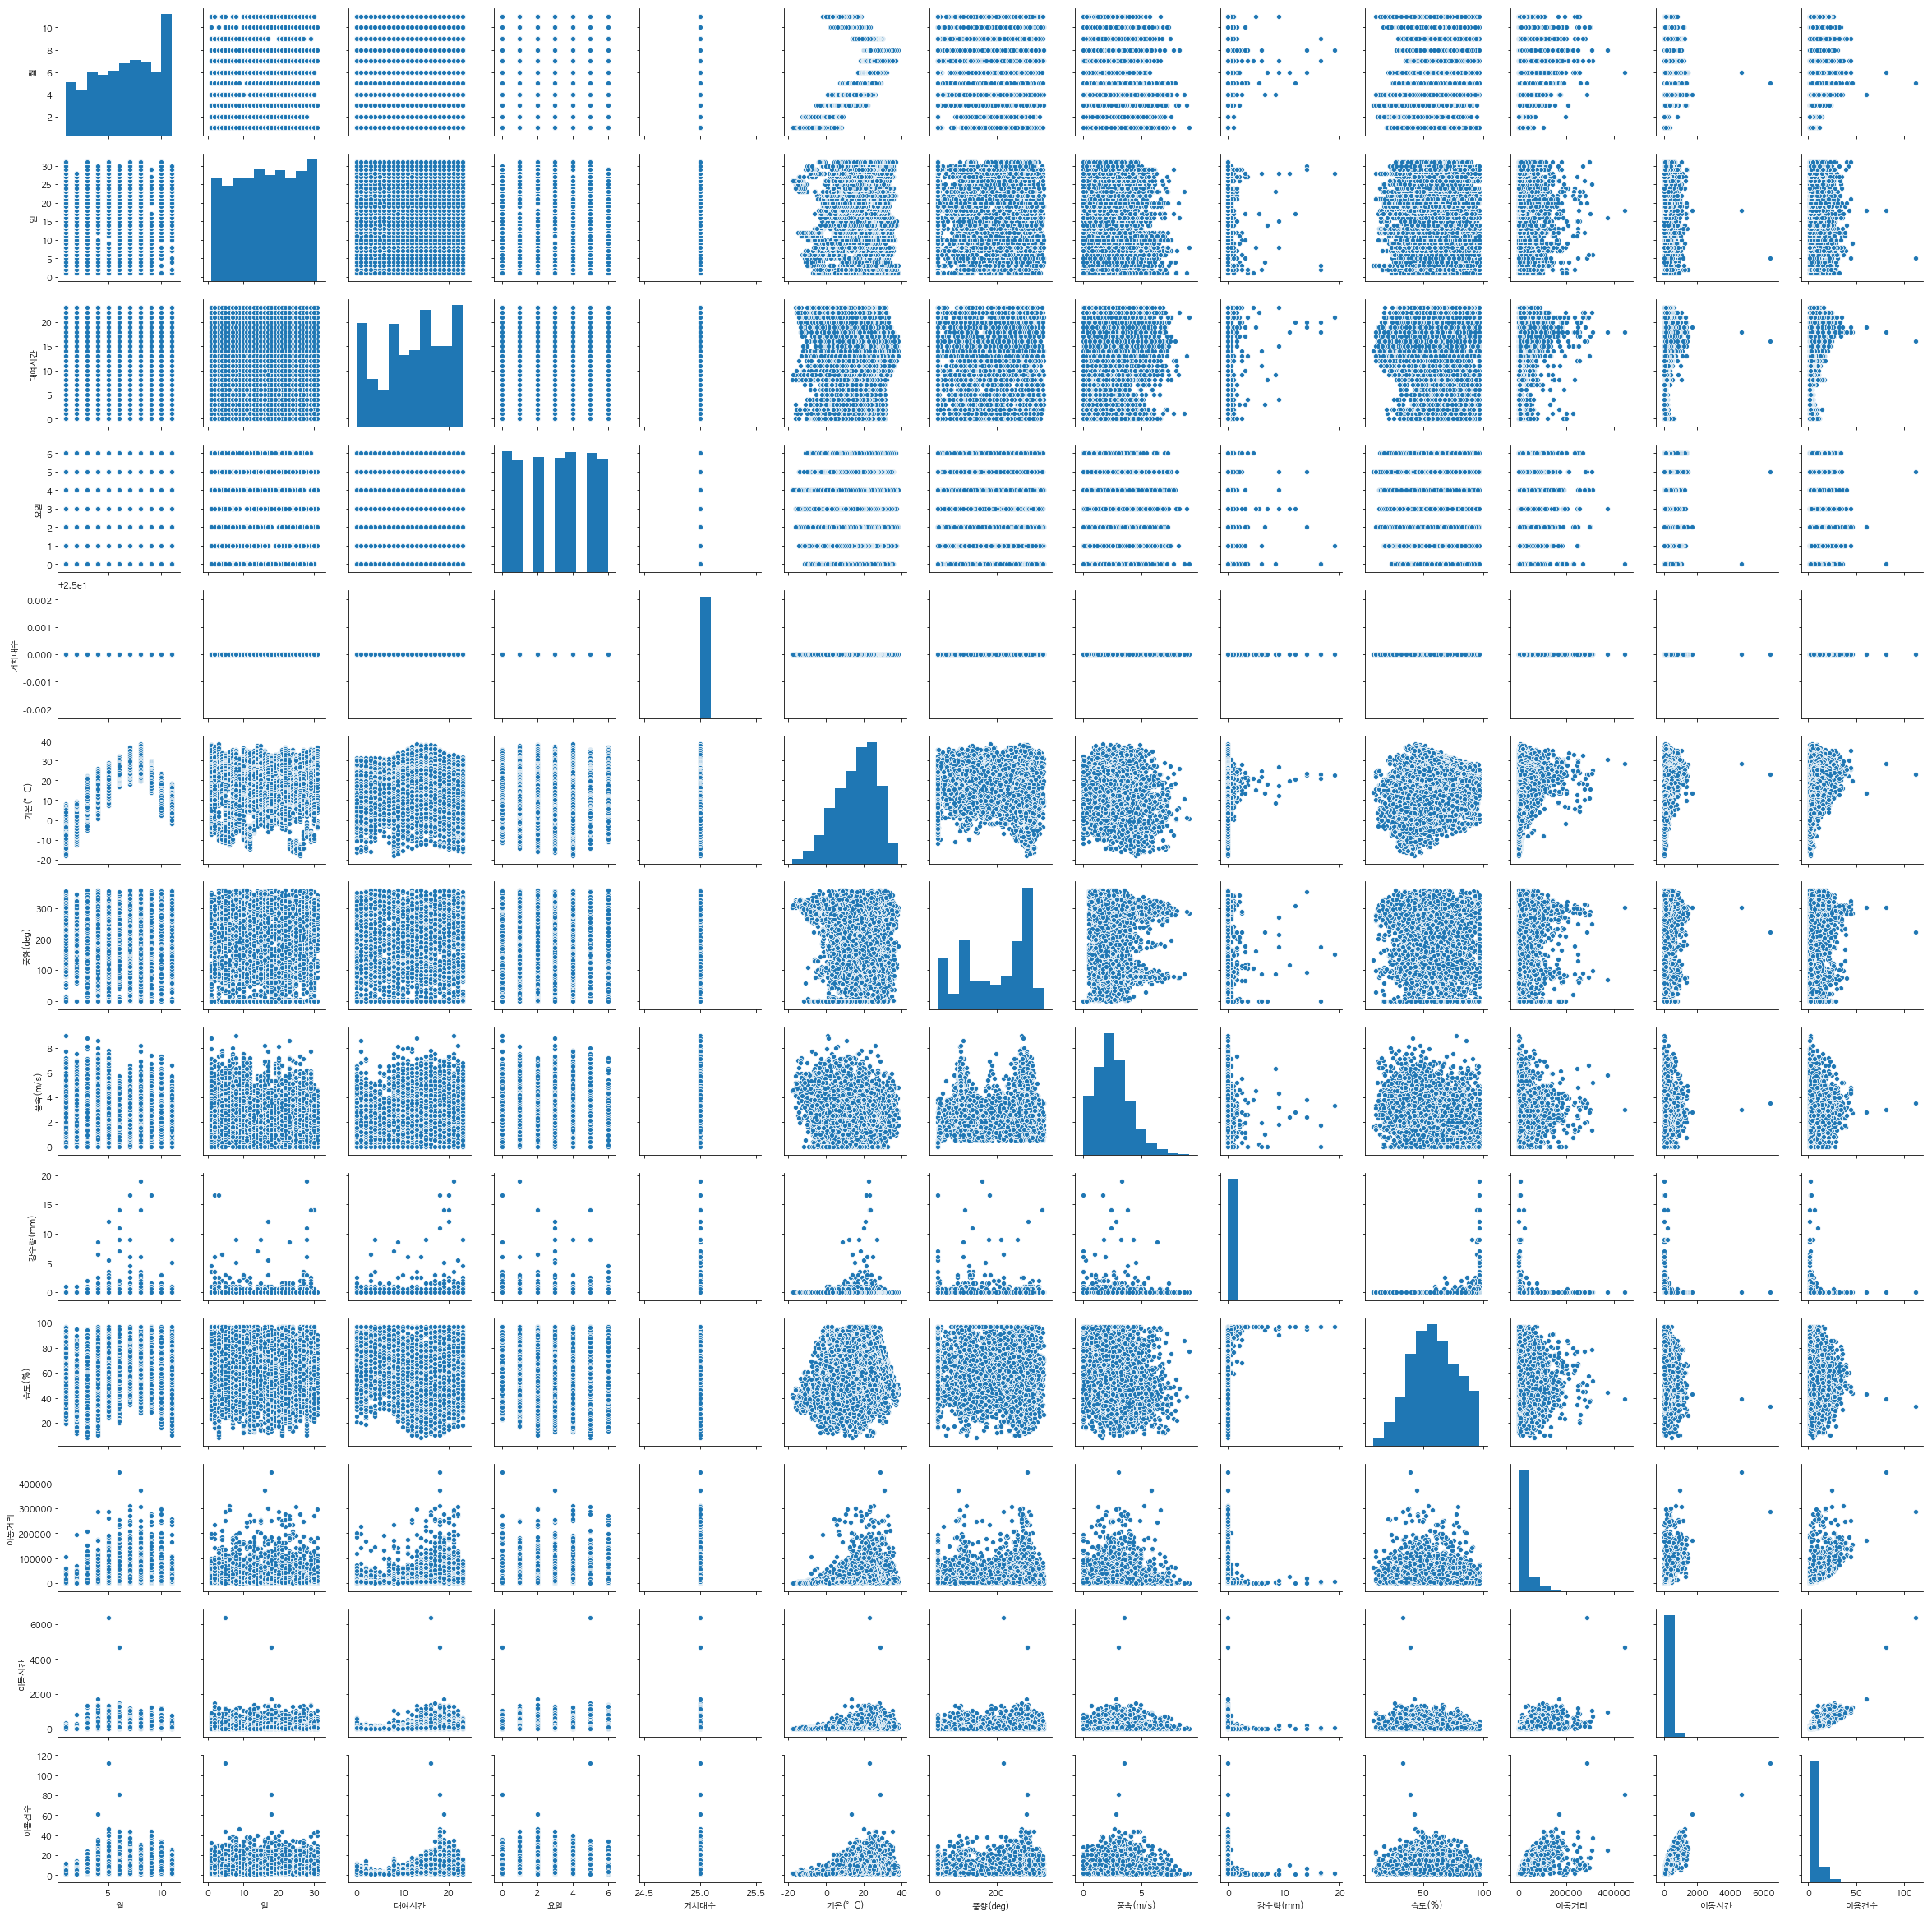

In [82]:
sns.pairplot(hongdae)
plt.show()

사실 핵심만 보고싶으면, **가장 마지막 행(이용건수 - 다른 피처)**만 보면 된다.

월, 대여시간, 요일, 기온, 풍속, 강수량, 습도, 이동거리, 이용시간이 피처로 쓸모있어 보인다.  
하지만 여기서, 우리는 이동거리(평균), 이용시간(평균)은 사용할 수 없는데, 이유는 '예측'이라는 측면에서, 다른 피처들은 사전에 미리 알 수 있는데에 반해,  
이동거리, 이용시간은 사전에 미리 알 수 없기 때문이다.

## 2. 모델링

### 1) Feature Engineering

In [36]:
hongdae.columns.values

array(['월', '일', '대여시간', '요일', '거치대수', '기온(°C)', '풍향(deg)', '풍속(m/s)',
       '강수량(mm)', '습도(%)', '이동거리', '이동시간', '이용건수'], dtype=object)

요일의 경우, 0-6의 값을 가지는데, 이를 one-hot vector로 바꿔주자.

In [37]:
hongdae = hongdae.join(pd.get_dummies(hongdae['요일'], prefix="요일"))
hongdae.head()

,월,일,대여시간,요일,거치대수,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),이동거리,이동시간,이용건수,요일_0,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6
0,1,1,1,0,25,-2.0,334.4,2.0,0.0,42.2,2620.0,16.0,2,1,0,0,0,0,0,0
1,1,1,2,0,25,-2.6,305.5,2.0,0.0,42.7,2560.0,13.0,5,1,0,0,0,0,0,0
2,1,1,3,0,25,-2.6,308.1,1.1,0.0,46.3,10735.0,58.0,4,1,0,0,0,0,0,0
3,1,1,4,0,25,-2.9,314.8,1.0,0.0,49.6,2690.0,14.0,2,1,0,0,0,0,0,0
4,1,1,7,0,25,-2.9,345.4,0.8,0.0,50.4,1050.0,3.0,1,1,0,0,0,0,0,0


In [38]:
dayofweek = ["요일_"+str(i) for i in range(7)]
features = ['월', '대여시간', '기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)'] + dayofweek
features

['월',
 '대여시간',
 '기온(°C)',
 '풍향(deg)',
 '풍속(m/s)',
 '강수량(mm)',
 '습도(%)',
 '요일_0',
 '요일_1',
 '요일_2',
 '요일_3',
 '요일_4',
 '요일_5',
 '요일_6']

### 2) Train, Test 데이터 나누기

8:2 의 비율로 나누자.

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hongdae[features], hongdae['이용건수'], test_size=0.2, random_state=42)

In [40]:
print(X_train.shape)
print(X_test.shape)

(4931, 14)
(1233, 14)


학습용 데이터는 4931개, 테스트용 데이터는 1233개다.

### 3) 학습

scikit-learn 에 있는 regression 모델들을 모두 써보자.  

http://keunwoochoi.blogspot.com/2016/08/blog-post.html 을 참고하여, 파이프라인 및 그리드서치로 최적의 모델을 찾아보자.

In [147]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
import xgboost as xgb
from scipy.stats import uniform, randint

models = [
    ('lr', lm.LinearRegression(n_jobs=-1)),
    ('ridge', lm.Ridge()),
    ('lasso', lm.Lasso()),
    ('elastic', lm.ElasticNet()),
    ('LassoLars', lm.LassoLars()),
    ('LogisticRegression', lm.LogisticRegression()),
    ('SGDRegressor', lm.SGDRegressor()),
    ('Perceptron', lm.Perceptron(n_jobs=-1)),
    ('xgboost', xgb.XGBRegressor())
]
n = 3
params = {
    'lr' : {
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'ridge': {
        'alpha': [0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'lasso': {
        'alpha': [0.1, 1.0, 10],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'elastic': {
        'alpha': [0.1, 1.0, 10],
        'normalize': [True, False],
        'fit_intercept': [True, False],
    },
    'LassoLars': {
        'alpha': [0.1, 1.0, 10],
        'normalize': [True, False],
        'fit_intercept': [True, False],
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
    },
    'SGDRegressor': {
        'penalty': ['l1', 'l2'],
        'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
    },
    'Perceptron' :{
        'penalty': ['None', 'l1', 'l2'],
        'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False]
    },
    'xgboost': {
        "gamma": uniform(0, 0.5).rvs(n),
        "max_depth": range(2, 7), # default 3
        "n_estimators": randint(100, 150).rvs(n), # default 100
    }
}

best_model, best_mae = None, float('inf')
for model_name, model in models:
    param_grid = params[model_name]
    grid = GridSearchCV(model, cv=5, n_jobs=-1, param_grid=param_grid)
    grid = grid.fit(X_train, y_train)
    
    model = grid.best_estimator_
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    
    print(model_name, mae)
    
    if mae < best_mae:
        best_model = model

lr 3.8833164913159983
ridge 3.881354658798292
lasso 3.866179568483539
elastic 3.870124999973334
LassoLars 3.866140482260054
LogisticRegression 4.083536090835361
SGDRegressor 3441455489767.2954
Perceptron 4.334144363341443
xgboost 2.3835171429683597


**xgboost 모델이 MAE 2.38 정도로 제일 낮았다.**  
고로 xgboost 쓰도록 하자.  
`best_model` 에는 xgboost 모델이 저장되어있을 것이다.

In [148]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.35336819357599547,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=102,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

모델을 이루고 있는 피처의 중요도를 살펴보자.

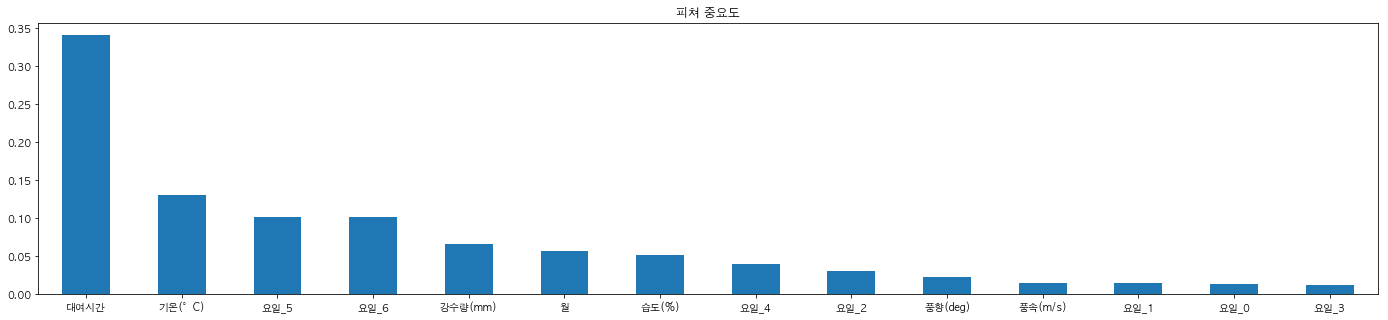

In [160]:
feature_importance = pd.Series(index=features, data=best_model.feature_importances_).sort_values(ascending=False)
feature_importance.plot(kind='bar', figsize=(24, 5), title="피쳐 중요도", rot=0)
plt.show()

대여시간이 압도적으로 영향이 큰가보다.  
그리고 요일_5, 요일_6은 토요일, 일요일을 말하는데, 주말이냐 아니냐도 생각보다 영향이 컸다.

이번엔, 예측값과 실제값, 그리고 오차값의 분포를 보자.

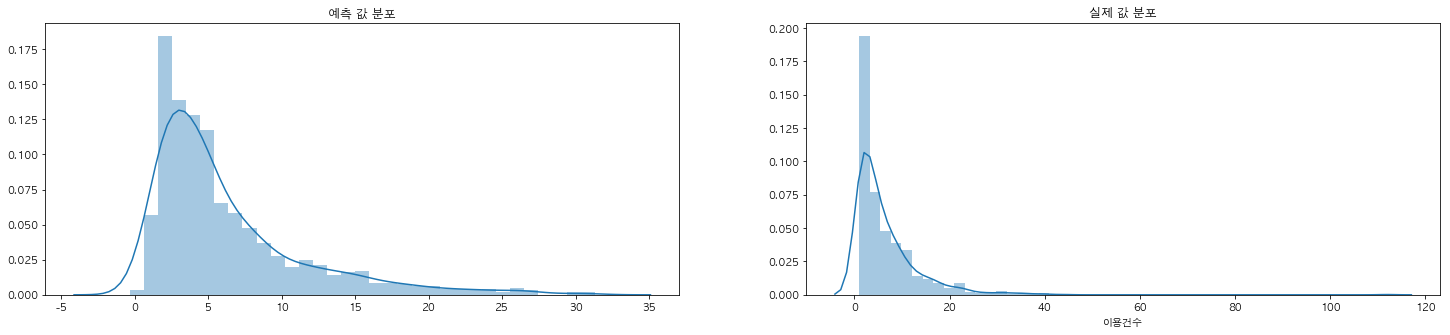

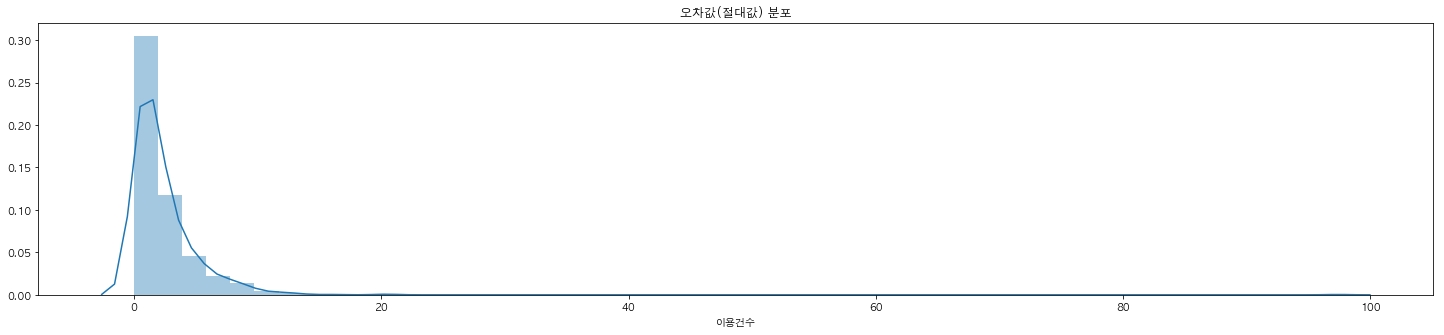

In [162]:
predictions = best_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(25, 5))
sns.distplot(predictions, ax=axes[0])
axes[0].set_title("예측 값 분포")
sns.distplot(y_test, ax=axes[1])
axes[1].set_title("실제 값 분포")
plt.show()

plt.figure(figsize=(25, 5))
sns.distplot(abs(predictions - y_test))
plt.title("오차값(절대값) 분포")
plt.show()

보면 실제값에 몇 이상치가 있음을 알 수 있다.  
우리 모델에서는 이런 이상치까지 잡지는 못했나보다.  
(아무래도 트레인 데이터에는 없고, 테스트 데이터에만 있는 이상치인가 보다. 일반적인 패턴이 아니라, **공휴일 등의 특정 이벤트였을 가능성**이 있다.)

이런 이상치 덕분에, 오차값에도 큰 이상치가 등장한다.  
**이런 이상치까지 예측할 수 있는 모델을 만들면, MAE가 떨어질 듯하다.**

자 이제 홍대입구역 앞 대여소 뿐만 아니라, **마포구에 있는 모든 대여소에 대한 각각의 모델들(xgboost로)을 만들어보자.**

In [42]:
n = 3

In [43]:
cols = ['월', '일', '대여시간', '요일', '거치대수', '기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

results = {}
total = df['대여소명'].nunique()

for idx, (name, _df) in enumerate(df.groupby('대여소명'), 1):
    print("[%d/%d] %s" %(idx, total, name), end=' ')
    
    try:
        _df = _df.groupby(cols)['이용건수'].sum().reset_index()
        _df = _df.join(pd.get_dummies(_df['요일'], prefix="요일"))
        
        print(_df.shape)

        X_train, X_test, y_train, y_test = train_test_split(_df[features], _df['이용건수'], test_size=0.2, random_state=42)

        param_grid = {
            "gamma": uniform(0, 0.5).rvs(n),
            "max_depth": range(2, 7), # default 3
            "n_estimators": randint(100, 150).rvs(n), # default 100
        }

        grid = GridSearchCV(xgb.XGBRegressor(), cv=5, n_jobs=-1, param_grid=param_grid)
        grid = grid.fit(X_train, y_train)

        model = grid.best_estimator_
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)

        results[name] = {}
        results[name]['model'] = model
        results[name]['mae'] = mae
        results[name]['errors'] = predictions - y_test
    
    except:
        continue

[1/75]  (구)합정동 주민센터 (2850, 18)
[2/75]  DMC빌 앞 (2211, 18)
[3/75]  DMC산학협력연구센터 앞 (3847, 18)
[4/75]  DMC역 2번출구 옆 (3998, 18)
[5/75]  DMC역 9번출구 앞 (4672, 18)
[6/75]  DMC첨단산업센터 (1050, 18)
[7/75]  DMC홍보관 (2946, 18)
[8/75]  LG CNS앞 (3022, 18)
[9/75]  SK망원동주유소 건너편 (4527, 18)
[10/75]  가좌역1 번출구 뒤 (3829, 18)
[11/75]  공덕역 2번출구 (3522, 18)
[12/75]  공덕역 5번출구 (3784, 18)
[13/75]  공덕역 8번출구 (4871, 18)
[14/75]  광흥창역 2번출구 앞 (4306, 18)
[15/75]  극동방송국 앞 (4259, 18)
[16/75]  누리꿈스퀘어 옆 (4311, 18)
[17/75]  대흥동 주민센터 (2421, 18)
[18/75]  롯데하이마트 (상암월드컵점)  (1318, 18)


/Users/heumsi/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[19/75]  마포 신수공원 앞 (3720, 18)
[20/75]  마포구 육아종합지원센터 (3098, 18)
[21/75]  마포구민체육센터 앞 (5201, 18)
[22/75]  마포구청 앞 (5103, 18)
[23/75]  마포구청역  (4884, 18)
[24/75]  마포소방서 앞 (3221, 18)
[25/75]  마포역 2번출구 뒤 (4322, 18)
[26/75]  마포역 4번출구 뒤 (4138, 18)
[27/75]  마포중앙도서관 (288, 18)
[28/75]  망원1동주민센터 (4197, 18)
[29/75]  망원2빗물펌프장 앞 (3626, 18)
[30/75]  망원역 1번출구 앞 (5293, 18)
[31/75]  망원역 2번출구 앞 (4712, 18)
[32/75]  망원초록길 입구 (918, 18)


/Users/heumsi/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[33/75]  문화비축기지 (1449, 18)


/Users/heumsi/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[34/75]  부엉이공원 앞 (2760, 18)
[35/75]  상수역 2번출구 앞 (4060, 18)
[36/75]  상암동주민센터 옆 (3159, 18)
[37/75]  상암월드컵파크 10단지 앞 (2906, 18)
[38/75]  상암월드컵파크 1단지 교차로 (3713, 18)
[39/75]  상암월드컵파크 3단지 후문 (2892, 18)
[40/75]  상암월드컵파크 7단지 앞 (2353, 18)
[41/75]  상암월드컵파크 9단지 앞 (3347, 18)
[42/75]  상암중학교 옆 (1985, 18)


/Users/heumsi/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[43/75]  상암한화오벨리스크 1차 앞 (3130, 18)
[44/75]  서강나루 공원 (3888, 18)
[45/75]  서강대 남문 옆 (4282, 18)
[46/75]  서강대 정문 건너편 (4446, 18)
[47/75]  서강대 후문 옆 (5033, 18)
[48/75]  서강대역 2번출구 앞 (4290, 18)
[49/75]  서교동 사거리 (4212, 18)
[50/75]  서울 월드컵 경기장 (2834, 18)


/Users/heumsi/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[51/75]  서울서부지방법원 앞 (3391, 18)
[52/75]  서울시 공공자전거 상암센터 (2069, 18)
[53/75]  서울신용보증재단 (1029, 18)


/Users/heumsi/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[54/75]  서울월드컵경기장 테스트 (1, 12)
[55/75]  성산2교 사거리 (5091, 18)
[56/75]  성산시영아파트 (2115, 18)
[57/75]  신성기사식당 앞 (4158, 18)
[58/75]  신수동 사거리 (2715, 18)
[59/75]  신촌역(2호선) 6번출구 옆 (3781, 18)
[60/75]  신촌역(2호선) 7번출구 앞 (4278, 18)
[61/75]  신한은행 서교동금융센터점 앞 (5343, 18)
[62/75]  아현역 4번출구 앞 (3479, 18)
[63/75]  애오개역 4번출구 앞 (4166, 18)
[64/75]  용강동 주민센터 앞 (3713, 18)
[65/75]  월드컵경기장역 3번출구 옆 (4081, 18)
[66/75]  월드컵공원 (2728, 18)
[67/75]  제일빌딩 앞 (4214, 18)
[68/75]  하늘채코오롱아파트 건너편 (5581, 18)
[69/75]  합정역 1번출구 앞 (4060, 18)
[70/75]  합정역 5번출구 앞 (3645, 18)
[71/75]  합정역 7번출구 앞 (5055, 18)
[72/75]  현대벤처빌 앞 (2635, 18)
[73/75]  홈플러스 앞 (4270, 18)
[74/75]  홍대입구역 2번출구 앞 (6164, 18)
[75/75]  홍대입구역 8번출구 앞 (4677, 18)


전체 평균 MAE를 보자.

In [55]:
errors = np.array([result['mae'] for result in results.values()])
errors.mean()

1.0325057764832608

전체 MAE 분포를 보자.

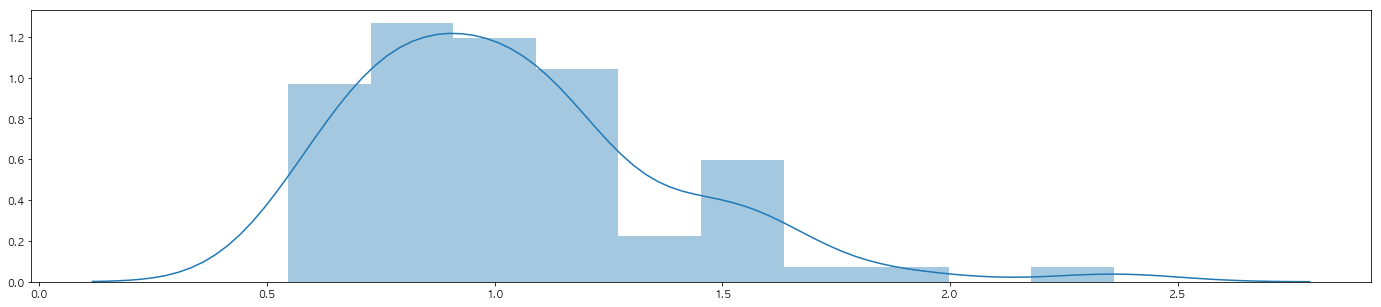

In [57]:
plt.figure(figsize=(24, 5))
sns.distplot(errors)
plt.show()

무난한 분포다. 평균을 대표값으로 채택해도 문제 없어보인다.

## 3. 정리

정리하면, 우리는 마포구 내 75개 대여소의 시간대별 대여건수 예측 모델을 만들어보았다.

- 각 대여소별로 모델을 가지며, 모델 베이스는 **xgboost regression 모델**이다.
- 모델에 **`[ '월', '대여시간', '요일', '기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']` 를 입력으로 주면, 해당 시간의 예측한 대여건수를 출력**해준다.
- 모델 예측 값이 실제값과 다른 정도는 0.5-3 의 값의 범위를 가지는데, 평균적으로는 1.0대, **즉 평균적으로 한 대 정도의 오차가 난다.**
  - 실제로는 대여소별로 예측하므로, 대여소별로 MAE(Mean absolute error) 를 보는게 맞긴 하다.
  
2018년 데이터 이므로, 2019년인 지금에 바로 적용가능하기엔 힘들겠지만,  
15년도부터 공개된 데이터셋을 모두 학습시키고, 실시간 시간과 날씨정보를 가져오면, 실시간으로 대여건수를 예측할 수 있겠다.  
나중에 시간되면 mapbox 를 이용해서 일종의 대여소별 예측 대여건수 대시보드 서비스를 만들어볼 생각이다.

*\*저도 아직 배우는 과정이라, 지금까지의 과정 중에, 오류가 있을 수 있습니다. 이상한 부분은 댓글로 남겨주시면 감사하겠습니다.*

## 4. 참고한 사이트
- xgboost 사용하기
  - [Using XGBoost with Scikit-learn](https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn)
  - [XGBoost 사용법](https://jungsooyun.github.io/misc/2018/02/19/XGBoost.html)
- regression model 과 grid_search
  - [Scikit-Learn and GridSearchCV](https://www.kaggle.com/cesartrevisan/scikit-learn-and-gridsearchcv)
  - [How To Grid-Search With A Pipeline](https://medium.com/@yoni.levine/how-to-grid-search-with-a-pipeline-93147835d916)
  - [세상에 있는 (거의) 모든 머신러닝 문제 공략법](http://keunwoochoi.blogspot.com/2016/08/blog-post.html)
  - [Pipelines + GridSearch = Awesome ML pipelines](https://www.kaggle.com/evanmiller/pipelines-gridsearch-awesome-ml-pipelines)
  - [scikit-learn documenation - 1.1. Generalized Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)

## 5. 데이터 출처
- 따릉이 데이터는 이전 포스팅과 동일.
- 기상 데이터는 [기상자료개방포털](https://data.kma.go.kr/)
- 이 내용에 해당하는 노트는 [여기서]() 확인할 수 있다.